# Imports

In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from src.data import *
from src.network import create_network
from src.app.main import create_dash_app

# Configs
plt.style.use('seaborn')

# Task description

Since we want to get a better understanding of your Python skills and how you approach a task, we ask you to send us a solution for this coding task.

Imagine we have a new customer who provides us a small dataset and wants to get some insights about his fleet.

Your task is to perform a little data exploration on the provided data and then apply simple anomaly detection techniques. <br>
Support your findings with plots, when possible and when it makes sense. <br>
Do not forget to comment your code and write a final conclusion when you are done.

As a dataset for this small task, we use data of trains operating in Finland, which is accesible through an API (https://www.digitraffic.fi/en/railway-traffic/).

# Your Approach

Perform the following steps:
1. Load the data from the API (use at least one month of data)
2. Perform data exploration to get a better understanding of the data, which information is it providing and describe what you find. 
    - See this step also as preparation for the next one
    - Consider that the column 'timeTableRows' contains further, embedded information
    - Important aspects could also be cancellations, delays and their causes


3. Try to find anomalies taking into account: 
    - Number of stations on the way
    - Total time from entry point to final destination

# Trains Data

In [2]:
# Loading past 30 days trains data
df = load_cleaned_trains()
df.head()

,trainNumber,departureDate,operatorUICCode,operatorShortCode,trainType,trainCategory,commuterLineID,runningCurrently,cancelled,version,timetableType,timetableAcceptanceDate,timeTableRows,numberStopedStations,trainDuration,routeEmbedding
0,1,2022-03-23,10,vr,IC,Long-distance,NaN,False,False,282234913730,REGULAR,2021-11-05 10:07:11+00:00,"[{'stationShortCode': 'HKI', 'stationUICCode':...",13,0 days 04:36:45,HKI-PSL-KÄP-OLK-PMK-ML-TNA-PLA-TKL-HKH-HVK-KVY...
1,3,2022-03-23,10,vr,IC,Long-distance,NaN,False,False,282238935859,REGULAR,2021-11-05 10:07:11+00:00,"[{'stationShortCode': 'HKI', 'stationUICCode':...",12,0 days 05:04:23,HKI-PSL-KÄP-OLK-PMK-ML-TNA-PLA-TKL-HKH-HVK-KVY...
2,4,2022-03-23,10,vr,IC,Long-distance,NaN,False,False,282237863999,REGULAR,2021-11-05 10:07:11+00:00,"[{'stationShortCode': 'JNS', 'stationUICCode':...",14,0 days 04:46:22,JNS-PLT-SUL-NTH-HSL-TKK-SÄ-KIT-PUS-KTI-POI-SR-...
3,5,2022-03-23,10,vr,IC,Long-distance,NaN,False,False,282238209378,REGULAR,2021-11-05 10:07:11+00:00,"[{'stationShortCode': 'HKI', 'stationUICCode':...",12,0 days 04:28:17,HKI-PSL-KÄP-OLK-PMK-ML-TNA-PLA-TKL-HKH-HVK-KVY...
4,6,2022-03-23,10,vr,IC,Long-distance,NaN,False,False,282237863999,REGULAR,2021-11-05 10:07:11+00:00,"[{'stationShortCode': 'JNS', 'stationUICCode':...",13,0 days 04:39:25,JNS-PLT-SUL-NTH-HSL-TKK-SÄ-KIT-PUS-KTI-POI-SR-...


In [3]:
# Data types
df.dtypes

trainNumber                              int64
departureDate                           object
operatorUICCode                          int64
operatorShortCode                       object
trainType                               object
trainCategory                           object
commuterLineID                          object
runningCurrently                          bool
cancelled                                 bool
version                                  int64
timetableType                           object
timetableAcceptanceDate    datetime64[ns, UTC]
timeTableRows                           object
numberStopedStations                     int64
trainDuration                  timedelta64[ns]
routeEmbedding                          object
dtype: object

In [4]:
# Data shape
df.shape

(52538, 16)

In [5]:
# Describe Data
df.drop(columns='timeTableRows').describe(include='all', datetime_is_numeric=True)

,trainNumber,departureDate,operatorUICCode,operatorShortCode,trainType,trainCategory,commuterLineID,runningCurrently,cancelled,version,timetableType,timetableAcceptanceDate,numberStopedStations,trainDuration,routeEmbedding
count,52538.000000,52538,52538.000000,52538,52538,52538,25454,52538,52538,5.253800e+04,52538,52538,52538.000000,52538,52538
unique,NaN,30,NaN,9,20,7,17,2,2,NaN,2,NaN,NaN,NaN,1495
top,NaN,2022-03-10,NaN,vr,HL,Commuter,K,False,False,NaN,REGULAR,NaN,NaN,NaN,KE-SAV-KRS-HNA-RKL-KVY-HVK-HKH-TKL-PLA-TNA-ML-...
freq,NaN,1945,NaN,51413,25108,25454,5783,52051,46262,NaN,43475,NaN,NaN,NaN,2941
mean,18206.254901,NaN,97.887872,NaN,NaN,NaN,NaN,NaN,NaN,2.821118e+11,NaN,2021-11-22 00:18:33.657580800+00:00,9.721858,0 days 01:31:53.970764018,NaN
min,1.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.818927e+11,NaN,2021-08-23 06:01:59+00:00,2.000000,-1 days +22:03:44,NaN
25%,8030.250000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.820516e+11,NaN,2021-11-05 10:07:11+00:00,3.000000,0 days 00:29:00,NaN
50%,8920.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.821116e+11,NaN,2021-11-05 10:07:11+00:00,8.000000,0 days 00:50:37,NaN
75%,11440.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.821738e+11,NaN,2021-12-17 10:19:16+00:00,15.000000,0 days 01:39:24,NaN
max,89686.000000,NaN,9999.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.822393e+11,NaN,2022-03-23 19:39:14+00:00,28.000000,1 days 04:07:58,NaN


### Number of stops

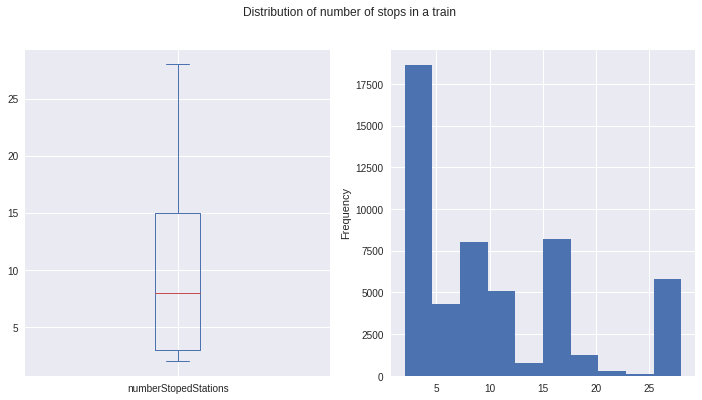

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
df['numberStopedStations'].plot(kind='box', ax=ax1)
df['numberStopedStations'].plot(kind='hist', ax=ax2)

plt.suptitle('Distribution of number of stops in a train')
plt.show()

#### Number of stops by train category

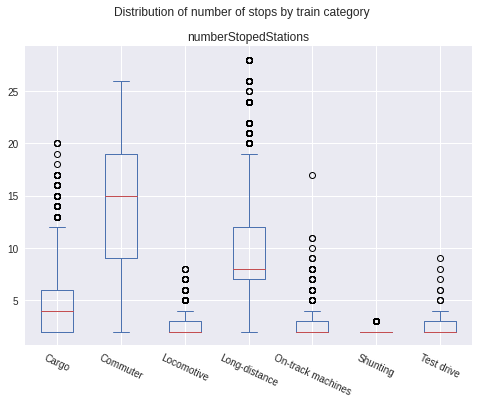

In [7]:
df[['numberStopedStations', 'trainCategory']].plot(kind='box', by='trainCategory')
plt.suptitle('Distribution of number of stops by train category')
plt.xticks(rotation=-25)

plt.show()

### Train duration

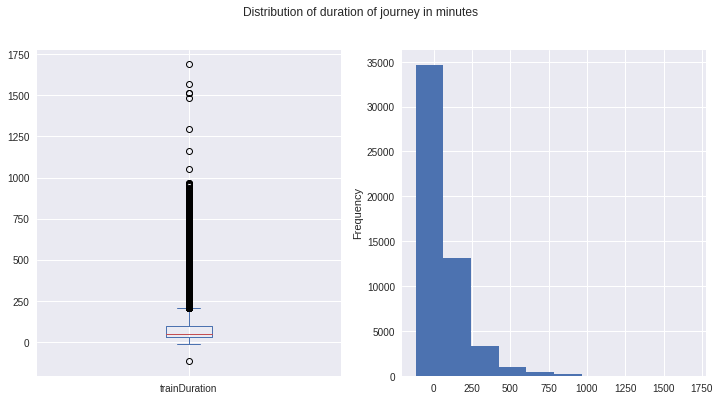

In [8]:
# Data 
total_minutes = df['trainDuration'].dt.total_seconds().div(60)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
total_minutes.plot(kind='box', ax=ax1)
total_minutes.plot(kind='hist', ax=ax2)

plt.suptitle('Distribution of duration of journey in minutes')
plt.show()

#### Train duration by train category

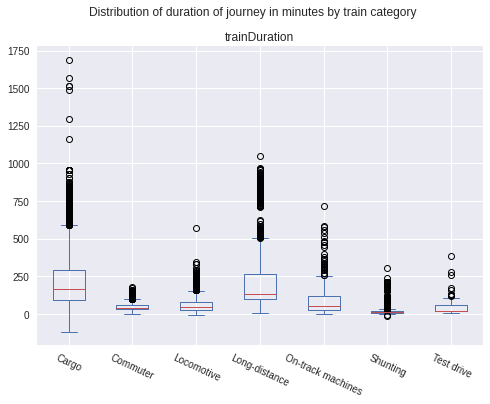

In [9]:
# data
total_minutes = pd.concat(
    (df['trainDuration'].dt.total_seconds().div(60), df['trainCategory']),
    axis=1
)

total_minutes.plot(kind='box', by='trainCategory')
plt.suptitle('Distribution of duration of journey in minutes by train category')
plt.xticks(rotation=-25)

plt.show()

#### Negative duration

**We should talk with customer to find out the reason behind the negative duration!**

In [10]:
# Trains with negative duration
df.loc[df['trainDuration']<timedelta(0)]

,trainNumber,departureDate,operatorUICCode,operatorShortCode,trainType,trainCategory,commuterLineID,runningCurrently,cancelled,version,timetableType,timetableAcceptanceDate,timeTableRows,numberStopedStations,trainDuration,routeEmbedding
11691,11343,2022-03-17,10,vr,VET,Locomotive,NaN,False,False,282181129796,ADHOC,2022-02-10 11:30:25+00:00,"[{'stationShortCode': 'RI', 'stationUICCode': ...",2,-1 days +23:53:13,RI-R702-SAM-RY-LK-TU-HRV-HL
34243,11505,2022-03-04,10,vr,VET,Locomotive,NaN,False,False,282076367701,ADHOC,2022-02-17 12:02:30+00:00,"[{'stationShortCode': 'KE', 'stationUICCode': ...",2,-1 days +23:53:08,KE-KYT-HAA
34250,11512,2022-03-04,10,vr,VET,Locomotive,NaN,False,False,282076378745,ADHOC,2022-02-17 12:02:47+00:00,"[{'stationShortCode': 'HAA', 'stationUICCode':...",2,-1 days +23:57:16,HAA-KYT-KE
34252,11514,2022-03-04,10,vr,VET,Locomotive,NaN,False,False,282076380308,ADHOC,2022-02-17 12:02:51+00:00,"[{'stationShortCode': 'HAA', 'stationUICCode':...",2,-1 days +23:57:46,HAA-KYT-KE
34254,11516,2022-03-04,10,vr,VET,Locomotive,NaN,False,False,282076382269,ADHOC,2022-02-17 12:02:55+00:00,"[{'stationShortCode': 'HAA', 'stationUICCode':...",2,-1 days +23:52:20,HAA-KYT-KE
34256,11518,2022-03-04,10,vr,VET,Locomotive,NaN,False,False,282076383964,ADHOC,2022-02-17 11:53:02+00:00,"[{'stationShortCode': 'HAA', 'stationUICCode':...",2,-1 days +23:53:59,HAA-KYT-KE
34360,53583,2022-03-04,10,vr,T,Cargo,NaN,False,False,282076184898,ADHOC,2022-01-19 08:38:18+00:00,"[{'stationShortCode': 'PIK', 'stationUICCode':...",2,-1 days +22:03:44,PIK-KUT-TKU
36505,65502,2022-03-03,10,vr,PAI,Shunting,NaN,False,False,282068831937,ADHOC,2022-03-02 13:41:28+00:00,"[{'stationShortCode': 'SOA', 'stationUICCode':...",2,-1 days +23:58:05,SOA-ILM
44705,60012,2022-02-26,10,vr,SAA,Shunting,NaN,False,False,282034952588,REGULAR,2021-11-05 10:07:11+00:00,"[{'stationShortCode': 'HKI', 'stationUICCode':...",2,-1 days +23:45:57,HKI-PSL-ILR
44729,60146,2022-02-26,10,vr,SAA,Shunting,NaN,False,False,282033485132,ADHOC,2021-12-20 14:20:14+00:00,"[{'stationShortCode': 'HKI', 'stationUICCode':...",2,-1 days +23:54:42,HKI-PSL-ILR


### Route Embeddings

What are the most frequent routes?

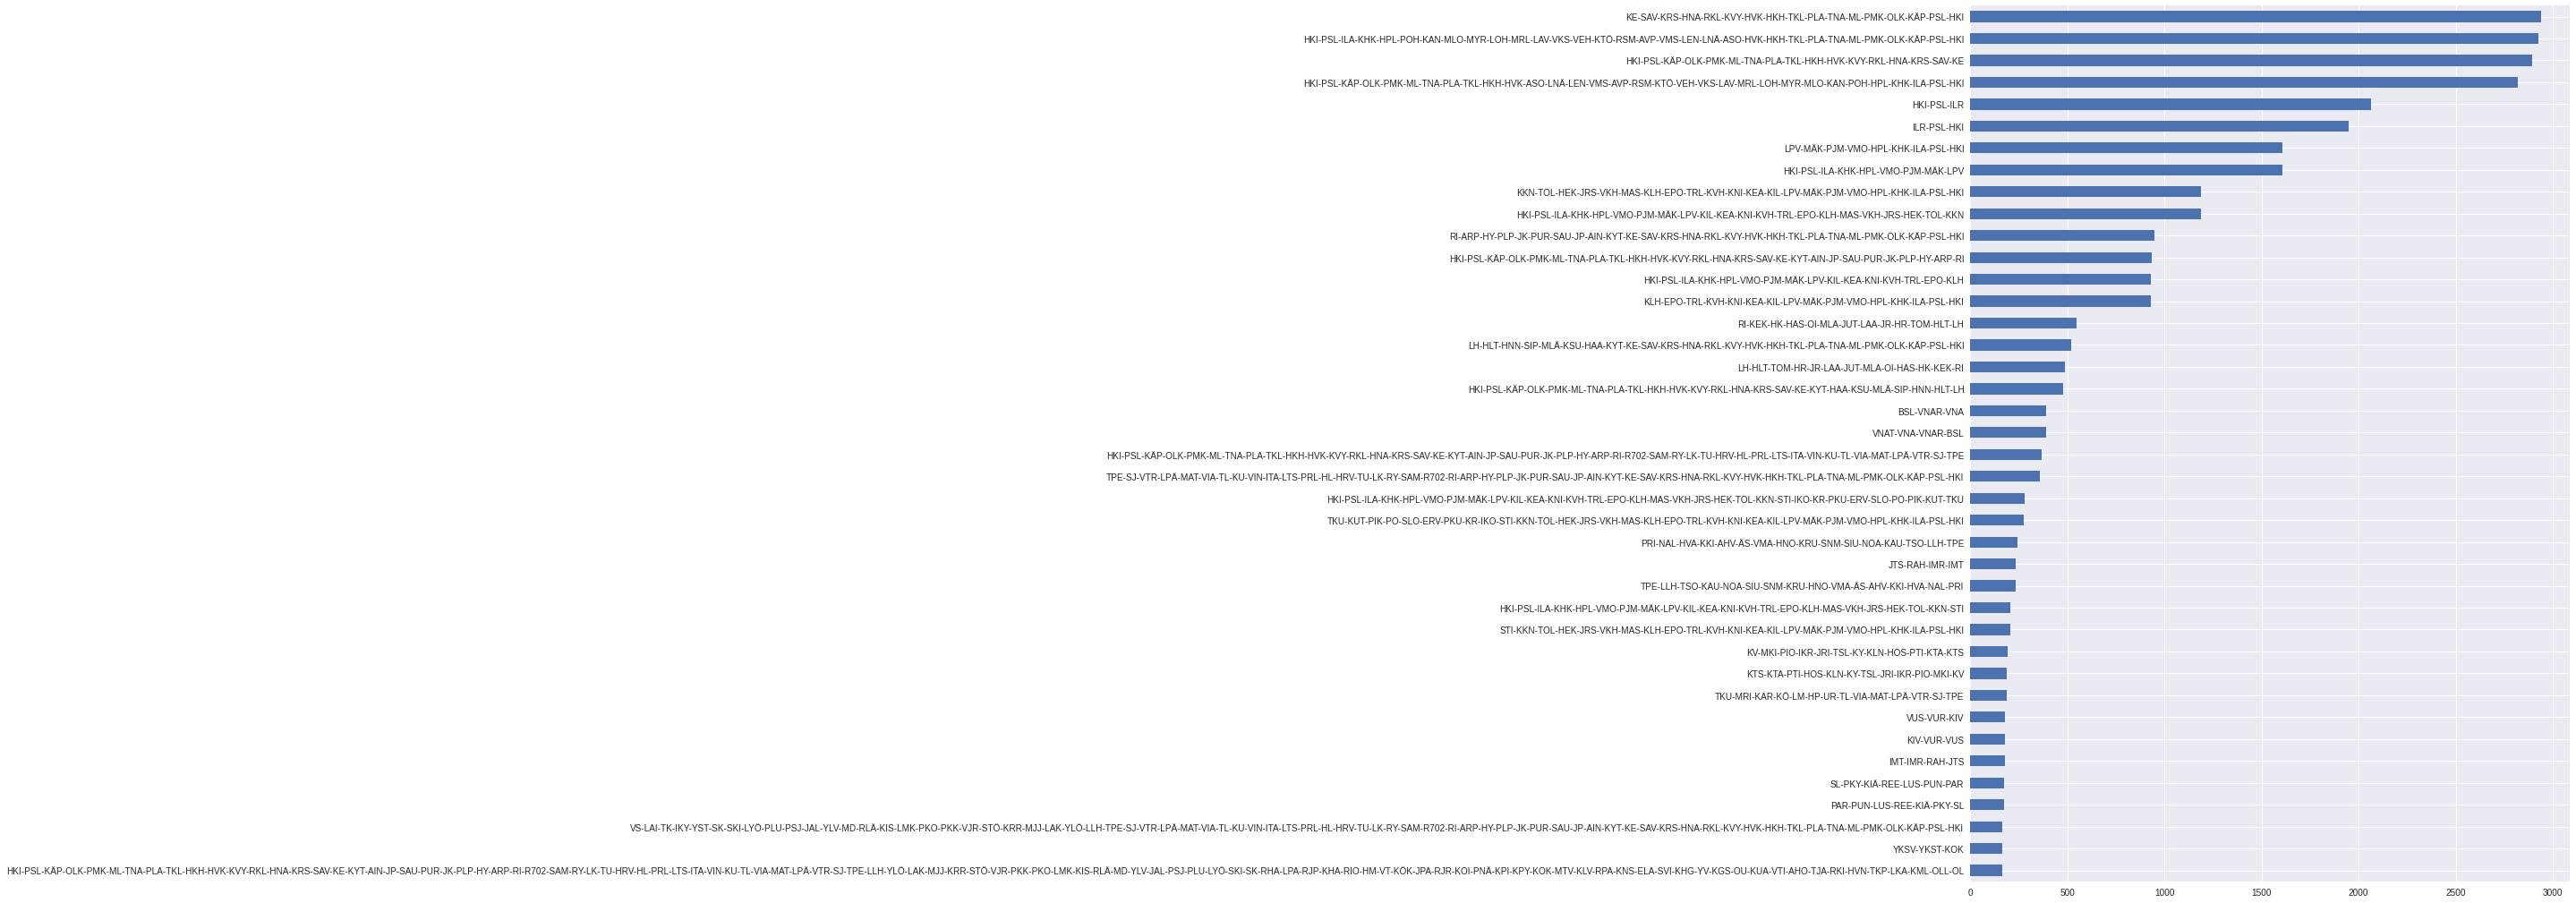

In [11]:
fig, ax = plt.subplots(figsize=(12,18))
df['routeEmbedding'].value_counts()[:40][::-1].plot(kind='barh', ax=ax)
plt.show()

## Network analysis

The Train data correspondes to multiple journeys across the stations. The network presented represents the average behaviour of these journeys with respect to the stations (nodes) and sections between stations (edges).

By modeling the railway as a weighted network, where the edges' weight corresponds to the average time (in minutes) between two stations, it is possible extract useful insights from the data.

For example:
- We can know whether any of the routes (from station A to B) is (or not) the shortest path
- We can find the most important nodes (in terms of network connectivity)
- We can find communities (i.e. subset of partitions of the network that are densily connected)

In [12]:
# Create the network
G = create_network(df)

------------ Creating nodes ------------
------------ Creating edges ------------
------------ Creating Graph object ------------


In [13]:
# Node attributes
G.nodes['AHO']

{'countryCode': 'FI',
 'counts': 2134,
 'stopFreq': 0.08341143392689784,
 'commercialFreq': 0.0009372071227741331,
 'cancelledFreq': 0.17057169634489222,
 'avgDiff': -1.1037204058624577,
 'typeArrivalFreq': 0.5,
 'typeDepartureFreq': 0.5,
 'passengerTraffic': False,
 'type': 'STATION',
 'stationName': 'Ahonpää',
 'longitude': 25.006783,
 'latitude': 64.537118}

In [14]:
# Edges attributes
G.edges[('AHO', 'TJA')]

{'avgDuration': 5.767605633802817}

#### Edges with negative average duration:
During development I have noticed that some durations were negative. After averaging the results no edge has a negative duration.

**This issue, together with the negative trainDuration values should be further discussed!**

We need to correct these to apply some algorithms.

In [15]:
# Edges with negative values
negative_edges = list(filter(lambda i: i[1]<=0, nx.get_edge_attributes(G, 'avgDuration').items()))
negative_edges

[(('HNK', 'HNKT'), 0.0)]

In [16]:
# Correcting any negative values
# for e in negative_edges:
#     G.edges[e[0]]['avgDuration'] = 0

### Analyze the network

#### Shortest path
Can the existent paths be optimized (without taking into account any logistical constraint)?

In [17]:
# Comparing some of the hot routes with their shortest path counterpart
top_10_routes = df['routeEmbedding'].value_counts()[:10].index
for i, route in enumerate(top_10_routes):
    r = route.split('-')
    print(f"Top {i} route: \t\t\t{route}\nCorresponding shortest path: \t{'-'.join(nx.shortest_path(G, r[0], r[-1], 'avgDuration'))}")

Top 0 route: 			KE-SAV-KRS-HNA-RKL-KVY-HVK-HKH-TKL-PLA-TNA-ML-PMK-OLK-KÄP-PSL-HKI
Corresponding shortest path: 	KE-SAV-KRS-HNA-RKL-KVY-HVK-HKH-TKL-PLA-TNA-ML-PMK-OLK-KÄP-PSL-HKI
Top 1 route: 			HKI-PSL-ILA-KHK-HPL-POH-KAN-MLO-MYR-LOH-MRL-LAV-VKS-VEH-KTÖ-RSM-AVP-VMS-LEN-LNÄ-ASO-HVK-HKH-TKL-PLA-TNA-ML-PMK-OLK-KÄP-PSL-HKI
Corresponding shortest path: 	HKI
Top 2 route: 			HKI-PSL-KÄP-OLK-PMK-ML-TNA-PLA-TKL-HKH-HVK-KVY-RKL-HNA-KRS-SAV-KE
Corresponding shortest path: 	HKI-PSL-KÄP-OLK-PMK-ML-TNA-PLA-TKL-HKH-HVK-KVY-RKL-HNA-KRS-SAV-KE
Top 3 route: 			HKI-PSL-KÄP-OLK-PMK-ML-TNA-PLA-TKL-HKH-HVK-ASO-LNÄ-LEN-VMS-AVP-RSM-KTÖ-VEH-VKS-LAV-MRL-LOH-MYR-MLO-KAN-POH-HPL-KHK-ILA-PSL-HKI
Corresponding shortest path: 	HKI
Top 4 route: 			HKI-PSL-ILR
Corresponding shortest path: 	HKI-PSL-ILA-ILR
Top 5 route: 			ILR-PSL-HKI
Corresponding shortest path: 	ILR-ILA-PSL-HKI
Top 6 route: 			LPV-MÄK-PJM-VMO-HPL-KHK-ILA-PSL-HKI
Corresponding shortest path: 	LPV-MÄK-PJM-VMO-HPL-KHK-ILA-PSL-HKI
Top 7 route: 			HKI-PSL-

In [18]:
# Why does ILA get suggested between PSL and ILR for the optimal route 4 and 5?
# - Because we have a single train with this route, it impacts the shortest path calculation.
# - This are like outliers that should not be included in this type of computation and should be removed.
df.loc[df['routeEmbedding'].str.contains('ILA-ILR'), 'routeEmbedding'].values

array(['TKU-KUT-PIK-PO-SLO-ERV-PKU-KR-IKO-STI-KKN-TOL-HEK-JRS-VKH-MAS-KLH-EPO-TRL-KVH-KNI-KEA-KIL-LPV-MÄK-PJM-VMO-HPL-KHK-ILA-ILR'],
      dtype=object)

- The shortest path seems to match the actual path in most cases, with the exception of rouding routes and some others because of the influence of outliers, as seen above.
- For the rounding routes we could treat them as a sort of Travel Salesman Problem and solve it that way, but it is more likely that these routes are already optimized because of the phisical constraints enforced by the railroad.

#### Centrality

What are the most important stations in the railroad?

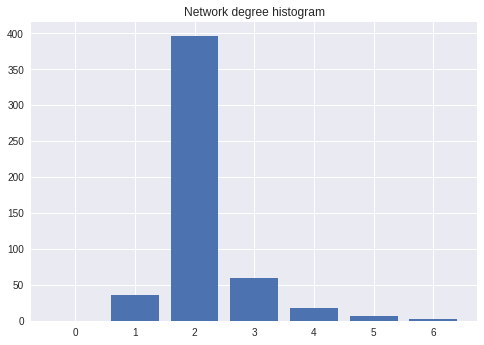

In [19]:
plt.bar(x=range(7), height=nx.degree_histogram(G))
plt.title('Network degree histogram')
plt.show()

- We can see that the majority of nodes are connected to two other nodes, no node is isolated and that the at most, a node is connected to 6 other nodes.

In [20]:
# The stations with higher degree are:
pd.Series(dict(G.degree())).sort_values(ascending=False).head(10)

KV     6
SK     6
PM     6
MKI    5
RI     5
KON    5
PSL    5
KUV    5
KE     5
HKO    4
dtype: int64

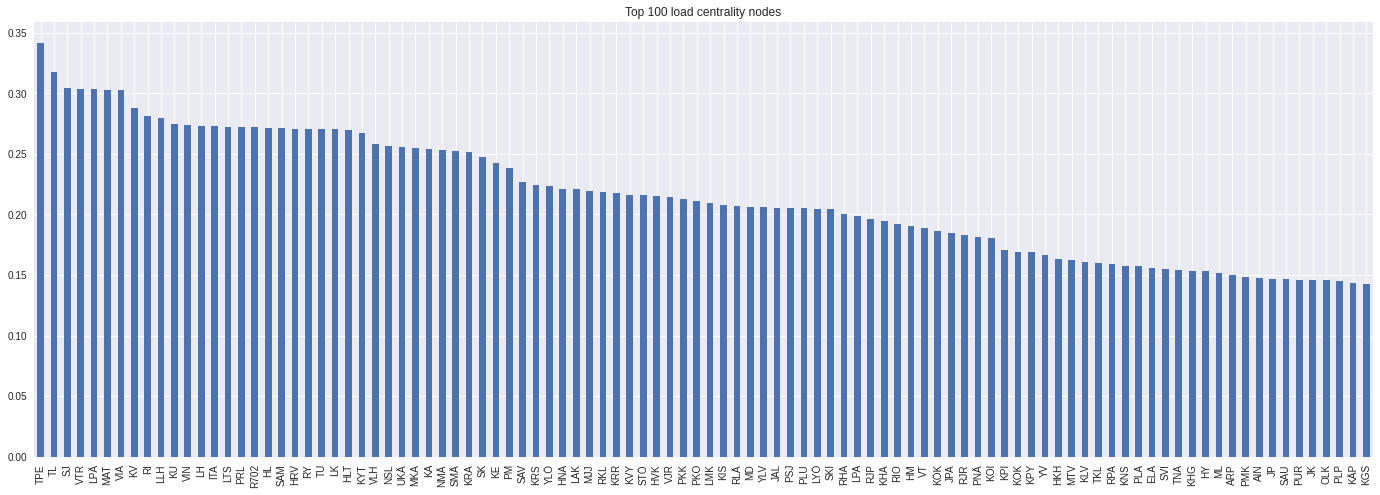

In [21]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.title("Top 100 load centrality nodes")
pd.Series(nx.load_centrality(G, weight='avgDuration')).sort_values(ascending=False)[:100].plot(kind='bar', ax=ax)
plt.show()

- Contrarily to degree centrality, load centrality gives us the fraction of all shortest paths that pass through a node.
- In this way, load centrality adapts gives us a more accurate representation of the importance of each node in the network.
- We can combine the information of both centrality measures:
    - the station KV has a degree of 6 and is in the 8th position in terms of load centrality, making it very important.

#### Communities
Do we have stations that are frequently run through together (i.e. clusters)?
- I expect that at least stations belonging to the commute line form a cluster

Modularity (Q): 
- measures the difference between the density of intra module connectivity of a proposed partition of the network with the expected number of links from a randomised network with the similar distribution of degrees.
- [Greedy Modularity Maximization algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities) is an hierarchical algorithm that joins (at each step) pairs of communities that maximize the modularity at that step (similar to Hierarchical Clustering).

In [22]:
# Calculate communities using the Greedy Modularity Maximization algorithm
partitions = nx.algorithms.community.greedy_modularity_communities(G, 'avgDuration', resolution=0.25)

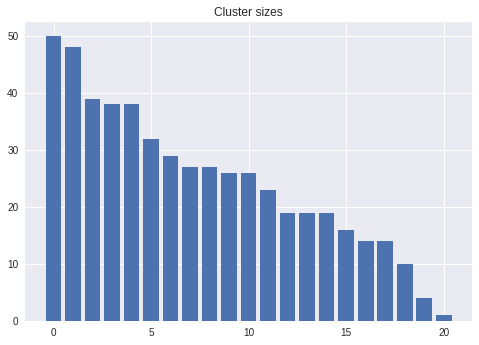

In [23]:
plt.title('Cluster sizes')
plt.bar(x=range(len(partitions)), height=[len(i) for i in partitions])
plt.show()

- In the next section we will be visualizing the network geographically and we use the cluster tags to help understand the communities

In [24]:
# Create node-community mapping
comm = {}
for i, p in enumerate(partitions):
    comm.update(dict(zip(p, [i]*len(p))))

### Visualize the network

In [25]:
# Create df_nodes from nodes attributes
df_nodes = pd.DataFrame.from_dict(dict(G.nodes.data()), orient='index')
df_nodes = df_nodes.reset_index().rename(columns={'index': 'stationShortCode'})

# Impute avgDiff with 0 (3 instances)
df_nodes['avgDiff'].fillna(0, inplace=True)

# Create community mapping
df_nodes['community'] = df_nodes['stationShortCode'].map(comm).astype(object)

# Create absolute delay variable (so it can be used in plot "size" attribute)
df_nodes['absAvgDiff'] = df_nodes['avgDiff'].abs()

df_nodes.head()

,stationShortCode,countryCode,counts,stopFreq,commercialFreq,cancelledFreq,avgDiff,typeArrivalFreq,typeDepartureFreq,passengerTraffic,type,stationName,longitude,latitude,community,absAvgDiff
0,AHO,FI,2134,0.083411,0.000937,0.170572,-1.103720,0.500000,0.500000,False,STATION,Ahonpää,25.006783,64.537118,8,1.103720
1,AHV,FI,2208,0.158514,0.000000,0.252717,-0.522182,0.500000,0.500000,False,STATION,Ahvenus,22.498185,61.291923,14,0.522182
2,AIN,FI,9197,0.532239,0.532021,0.027292,1.408681,0.499946,0.500054,True,STOPPING_POINT,Ainola,25.101494,60.456863,3,1.408681
3,ALH,FI,202,1.000000,1.000000,0.683168,1.803030,0.455446,0.544554,False,STATION,Alholma,22.695265,63.706765,15,1.803030
4,ALV,FI,428,0.967290,0.957944,0.074766,0.763819,0.502336,0.497664,True,STATION,Alavus,23.600437,62.617769,10,0.763819


In [26]:
# Create dash app given df_nodes
app = create_dash_app(df_nodes)

# Run dash app inline to explore the network
app.run_server(mode="inline")

# Change the filter to interact with the visualization and explore at will!

# Final conclusion 
## Please write 2-3 sentences about your findings and how you would interpret them/explain them to a customer

The findings throught the analysis can be summed up into the following points:
- The duration and number of stops of a journey are highly dependant on the train category
- The different stations form groups in terms of their relationship/connectivity
- There are problems relative to negative travelDuration values

These findings can be used to improve the railroad system by:
- implementing contigency plans in case of accidents or catastrophes (e.g. if a given station gets blocked what would be the best alternative route?);
- improving the existing routes using shortest path calculation;
- acting on stations with an higher delay occurrence;
- helping in the creation of new stations and connections (e.g. if the usage of a station is very high and it has only a degree of 1, then we might want to build a new connection to it)